# ARIMA Model on the Nifty 50 index 


In [1]:
!pip install arch
!pip install auquan-toolbox
!pip install yfinance

     |████████████████████████████████| 790 kB 431 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 103 kB 430 kB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=abc8477a3eb1f557ea33e6cdfe600892195a89ade7d3739826c712dbccebb840
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 5.5 MB 2.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=a5793cb7563354535d3a8ba265ca6644c064981cde446bc0b027a6d403e6de51
  Stored in directory: /root/.cache/pip/wheels/aa/8a/36/59ed4f6fbcb6100967618eeb0696046bf9777a41ac2ff1f9b9
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=

In [2]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import datetime
import yfinance as yf

%config InlineBackend.figure_format='retina'

In [3]:
nifty=yf.Ticker('^NSEI')
hist = nifty.history(period="max")
hist.index.name=None
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2020-12-04,13177.400391,13280.049805,13152.849609,13258.549805,640500,0,0
2020-12-07,13264.849609,13366.650391,13241.950195,13355.750000,591700,0,0
2020-12-08,13393.849609,13435.450195,13311.049805,13392.950195,543200,0,0
2020-12-09,13458.099609,13548.900391,13449.599609,13529.099609,502600,0,0
2020-12-10,13488.500000,13488.500000,13399.299805,13425.099609,0,0,0


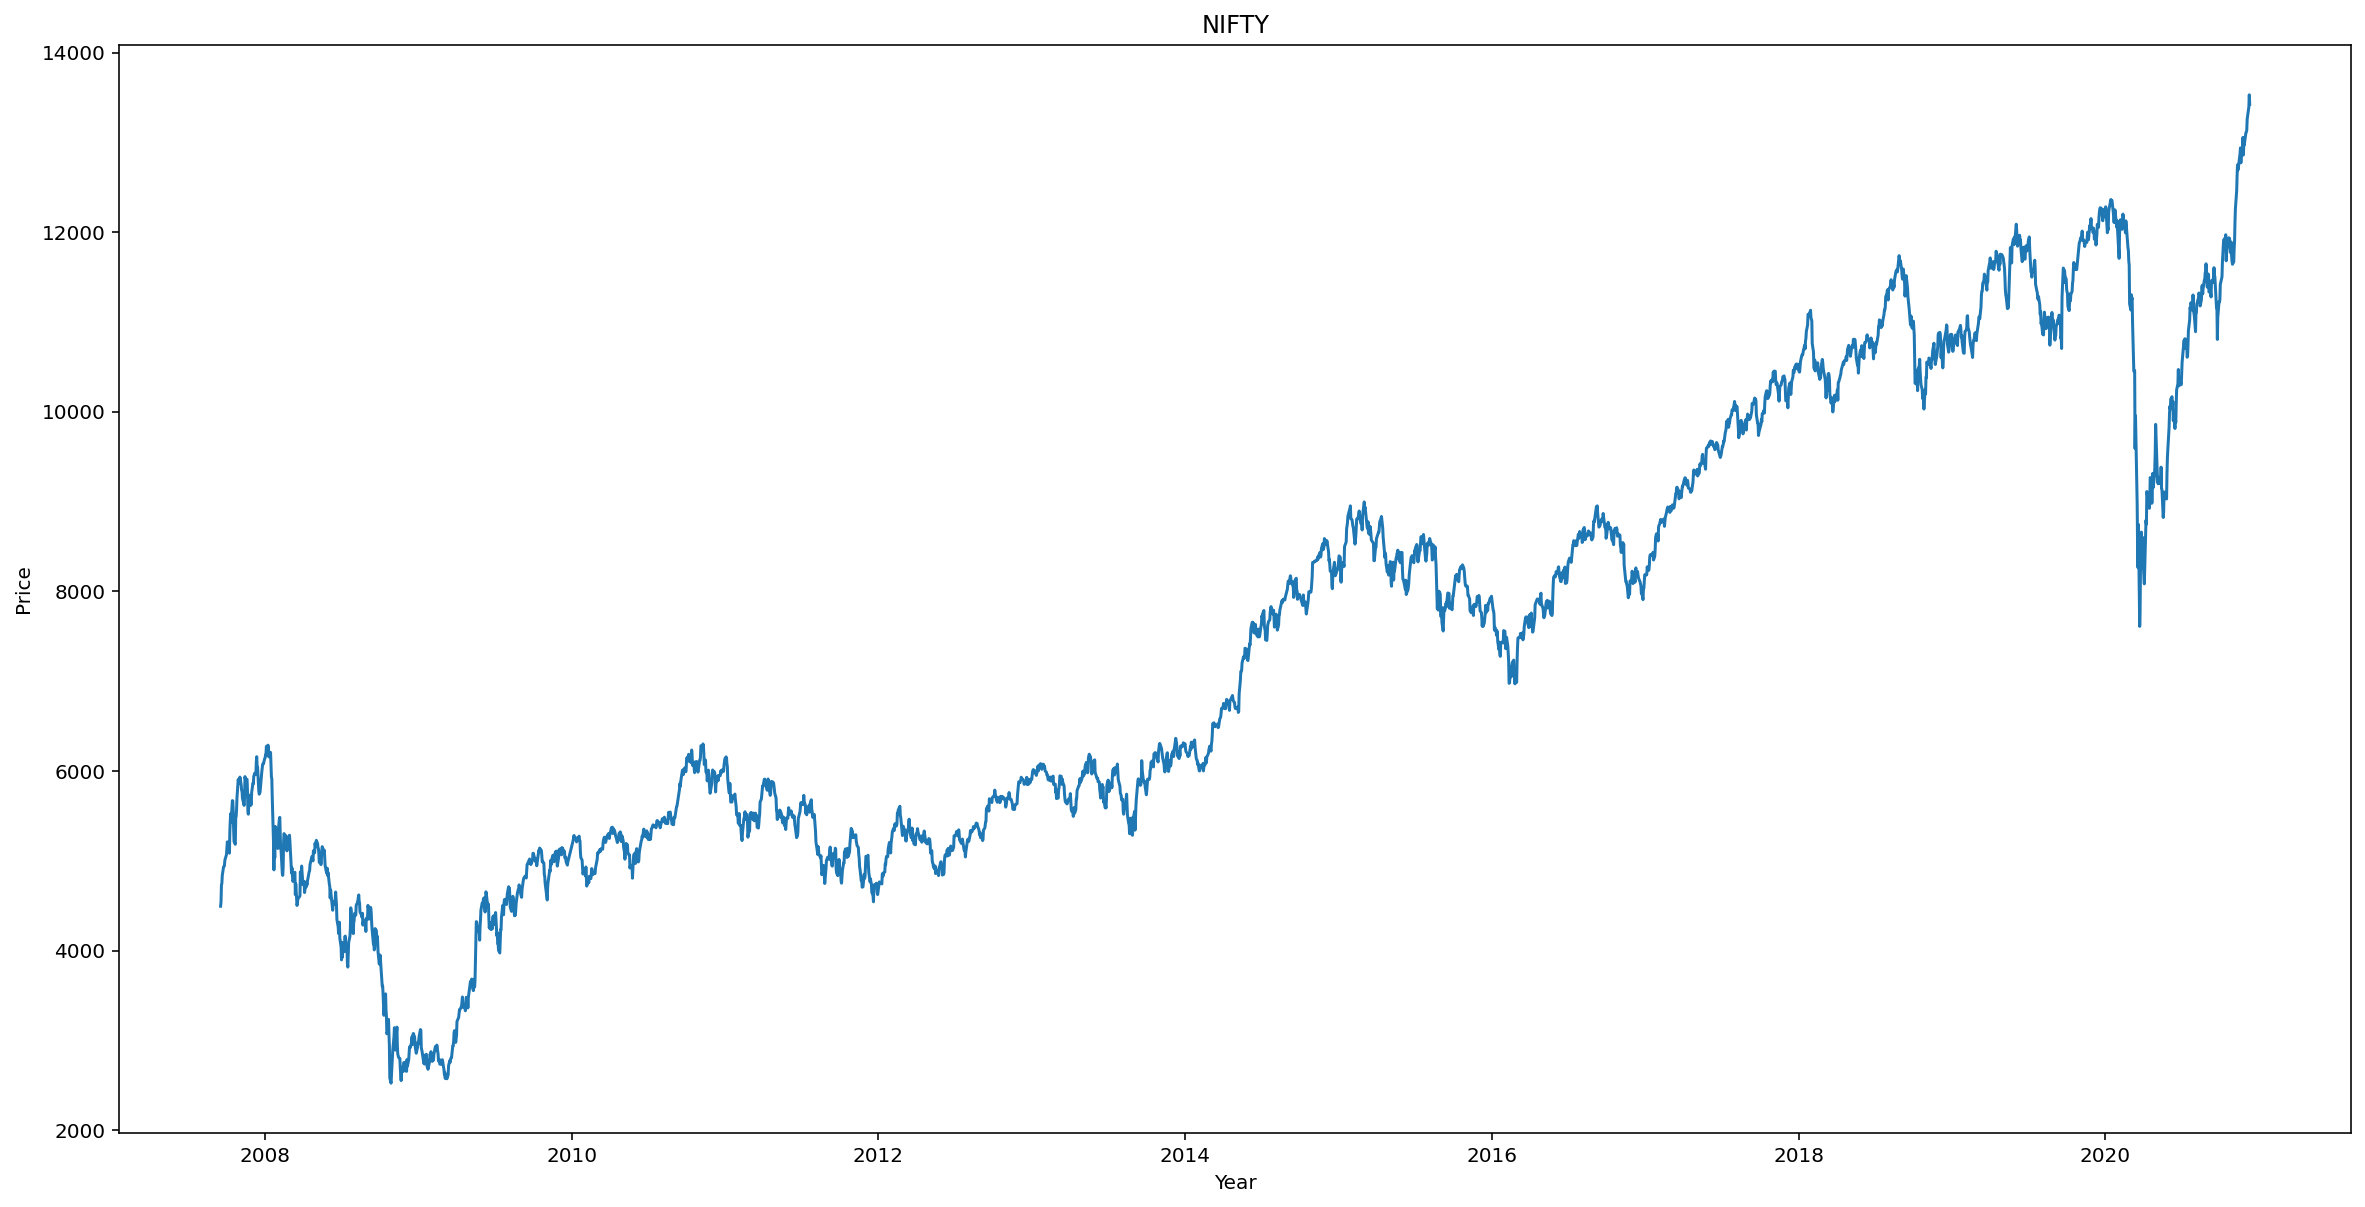

In [4]:
plt.figure(figsize=(20,10))
plt.plot(hist.index, hist.Close)
plt.title('NIFTY')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [5]:
lrets=np.log(hist.Close/hist.Close.shift(1)).dropna()
lrets.index = pd.DatetimeIndex(lrets.index.values,freq=lrets.index.inferred_freq)

In [6]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(lrets, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
if dfoutput[1]<.05:
    print('With a p-value < 0.05, we can reject the null hypothesis. This data set is stationary.')
else:
    print('Data is non stationary, pvalue > .05')

With a p-value < 0.05, we can reject the null hypothesis. This data set is stationary.


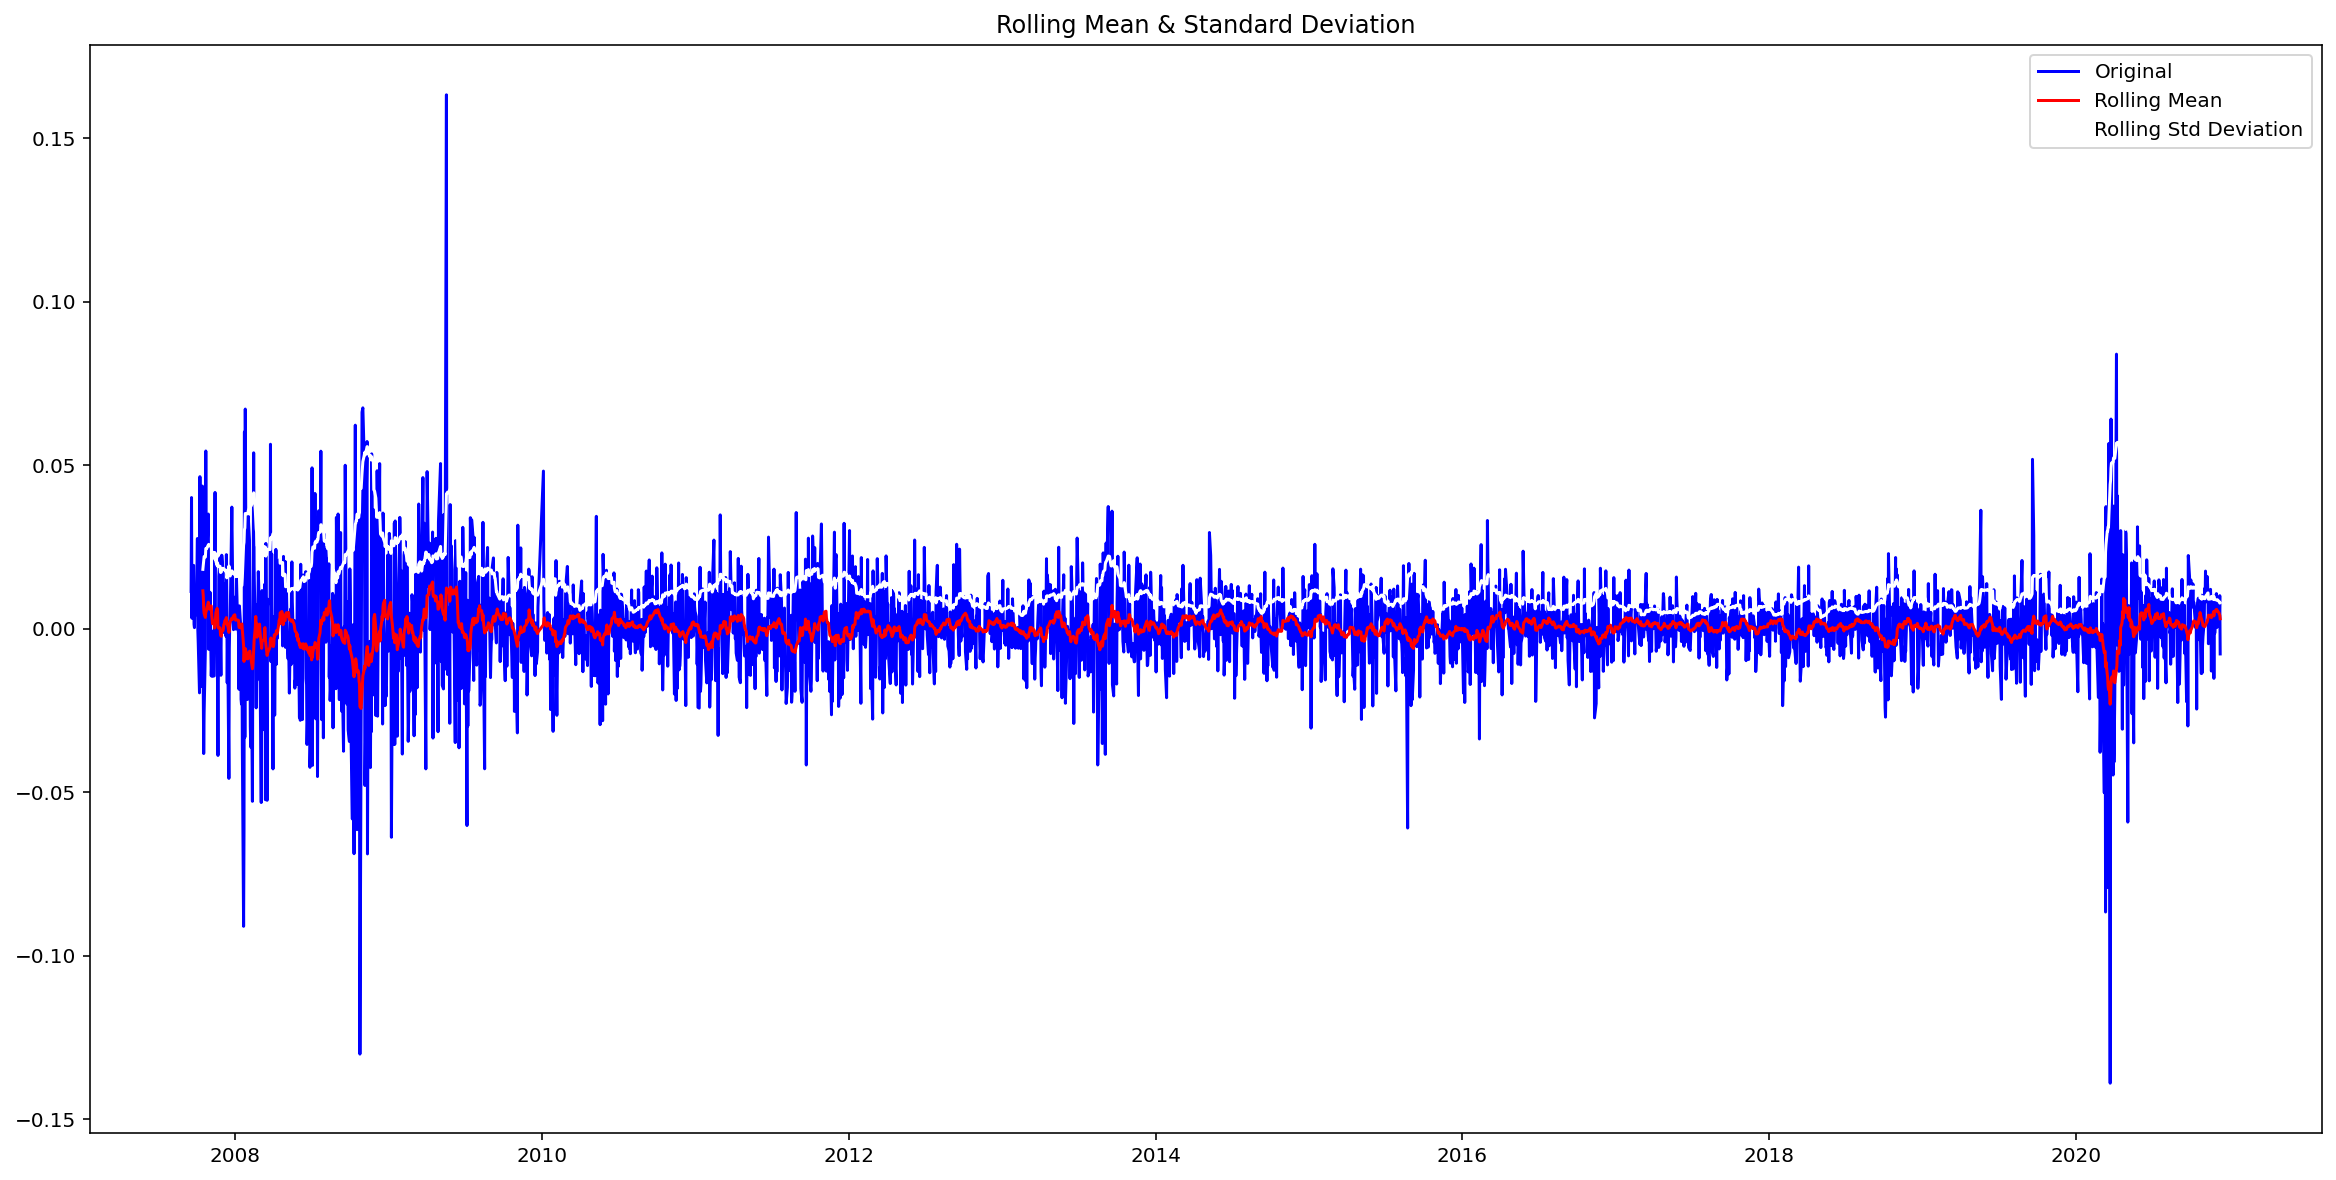

In [7]:
rolmean =lrets.rolling(20).mean()
rolstd = lrets.rolling(20).std()
plt.figure(figsize=(20, 10))
orig = plt.plot(lrets, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='white', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

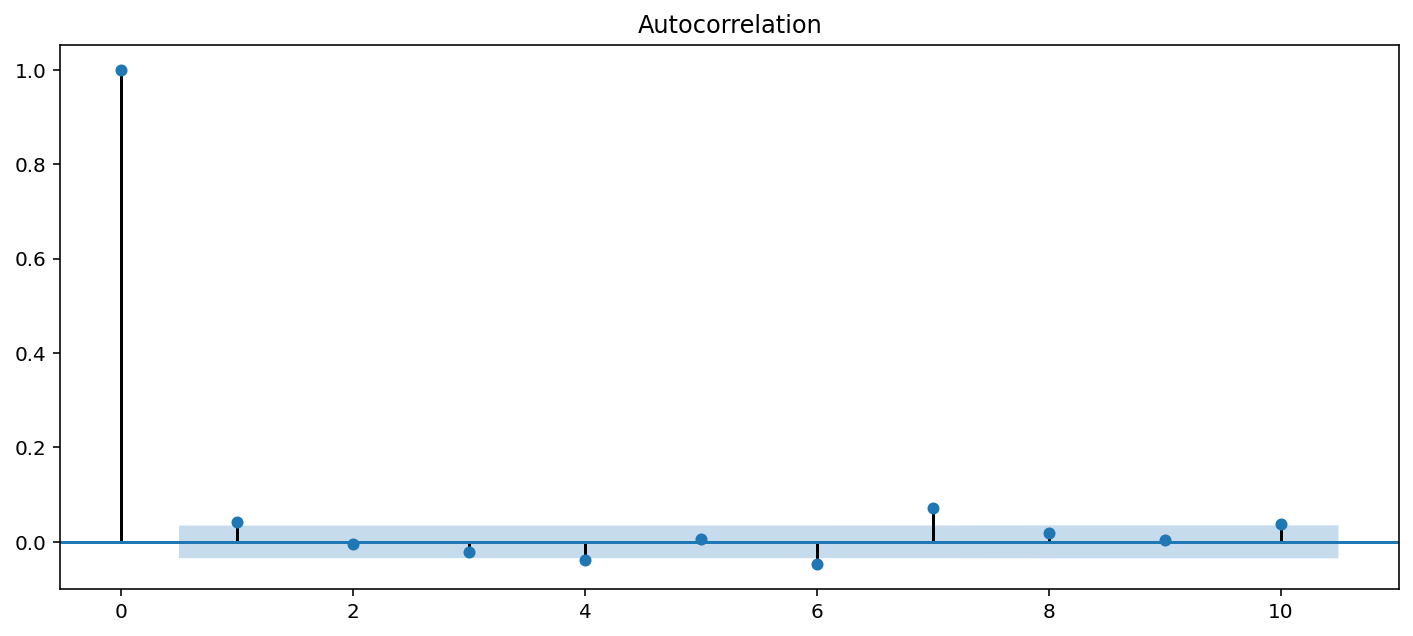

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(lrets, lags=10, ax=ax)
plt.show()

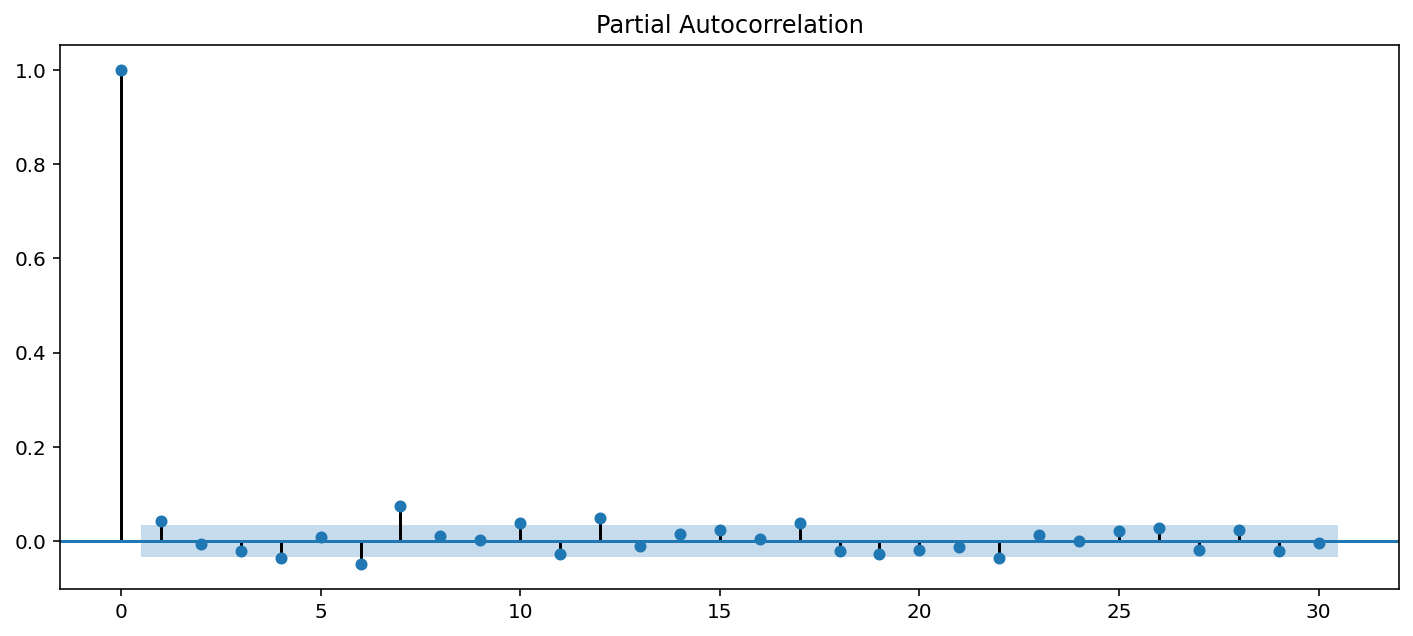

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(lrets, lags=30, ax=ax)
plt.show()

In [10]:
#Fit an Arima Model
ar1 = smt.ARIMA(lrets, order=(7,0,7)).fit(solver='bfgs',maxiter=1000)
ar1.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


         Current function value: -2.835012
         Iterations: 1000
         Function evaluations: 1169
         Gradient evaluations: 1169


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3233
Model:                     ARMA(7, 7)   Log Likelihood                9165.592
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 10 Dec 2020   AIC                         -18299.185
Time:                        07:21:44   BIC                         -18201.886
Sample:                             0   HQIC                        -18264.319
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0003      0.000      1.233      0.218      -0.000       0.001
ar.L1.Close    -0.8043      0.114     -7.069      0.000      -1.027      -0.581
ar.L2.Close     0.8307      0.144      5.767      0.000       0.548       1.113
ar.L3.Close     0.7234      0.111      6.532      0.000       0.506       0.940
ar.L4.Close    -1.0612      0.029    -36.840      0.000      -1.118      -1.005
ar.L5.Close    -0.6336      0.133     -4.778      0.000      -0.893      -0.374
ar.L6.Close     0.8125      0.136      5.990      0.000       0.547       1.078
ar.L7.Close     0.7398      0.089      8.312      0.000       0.565       0.914
ma.L1.Close     0.8405      0.109      7.716      0.000       0.627       1.054
ma.L2.Close    -0.8089      0.151     -5.363      0.000      -1.104      -0.513
ma.L3.Close    -0.7611      0.104     -7.297      0.000      -0.966      -0.557
ma.L4.Close     1.0417      0.028     37.343      0.000       0.987       1.096
ma.L5.Close     0.7071      0.123      5.761      0.000       0.467       0.948
ma.L6.Close    -0.8018      0.144     -5.557      0.000      -1.085      -0.519
ma.L7.Close    -0.7806      0.086     -9.055      0.000      -0.950      -0.612
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0576           -0.0000j            1.0576           -0.0000
AR.2            0.6974           -0.7170j            1.0002           -0.1272
AR.3            0.6974           +0.7170j            1.0002            0.1272
AR.4           -0.7916           -0.7157j            1.0672           -0.3830
AR.5           -0.7916           +0.7157j            1.0672            0.3830
AR.6           -0.9837           -0.3926j            1.0591           -0.4396
AR.7           -0.9837           +0.3926j            1.0591            0.4396
MA.1            1.0631           -0.0000j            1.0631           -0.0000
MA.2            0.6987           -0.7155j            1.0001           -0.1269
MA.3            0.6987           +0.7155j            1.0001            0.1269
MA.4           -0.7643           -0.7185j            1.0490           -0.3799
MA.5           -0.7643           +0.7185j            1.0490            0.3799
MA.6           -0.9795           -0.3681j            1.0464           -0.4428
MA.7           -0.9795           +0.3681j            1.0464            0.4428
-----------------------------------------------------------------------------
"""

In [11]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

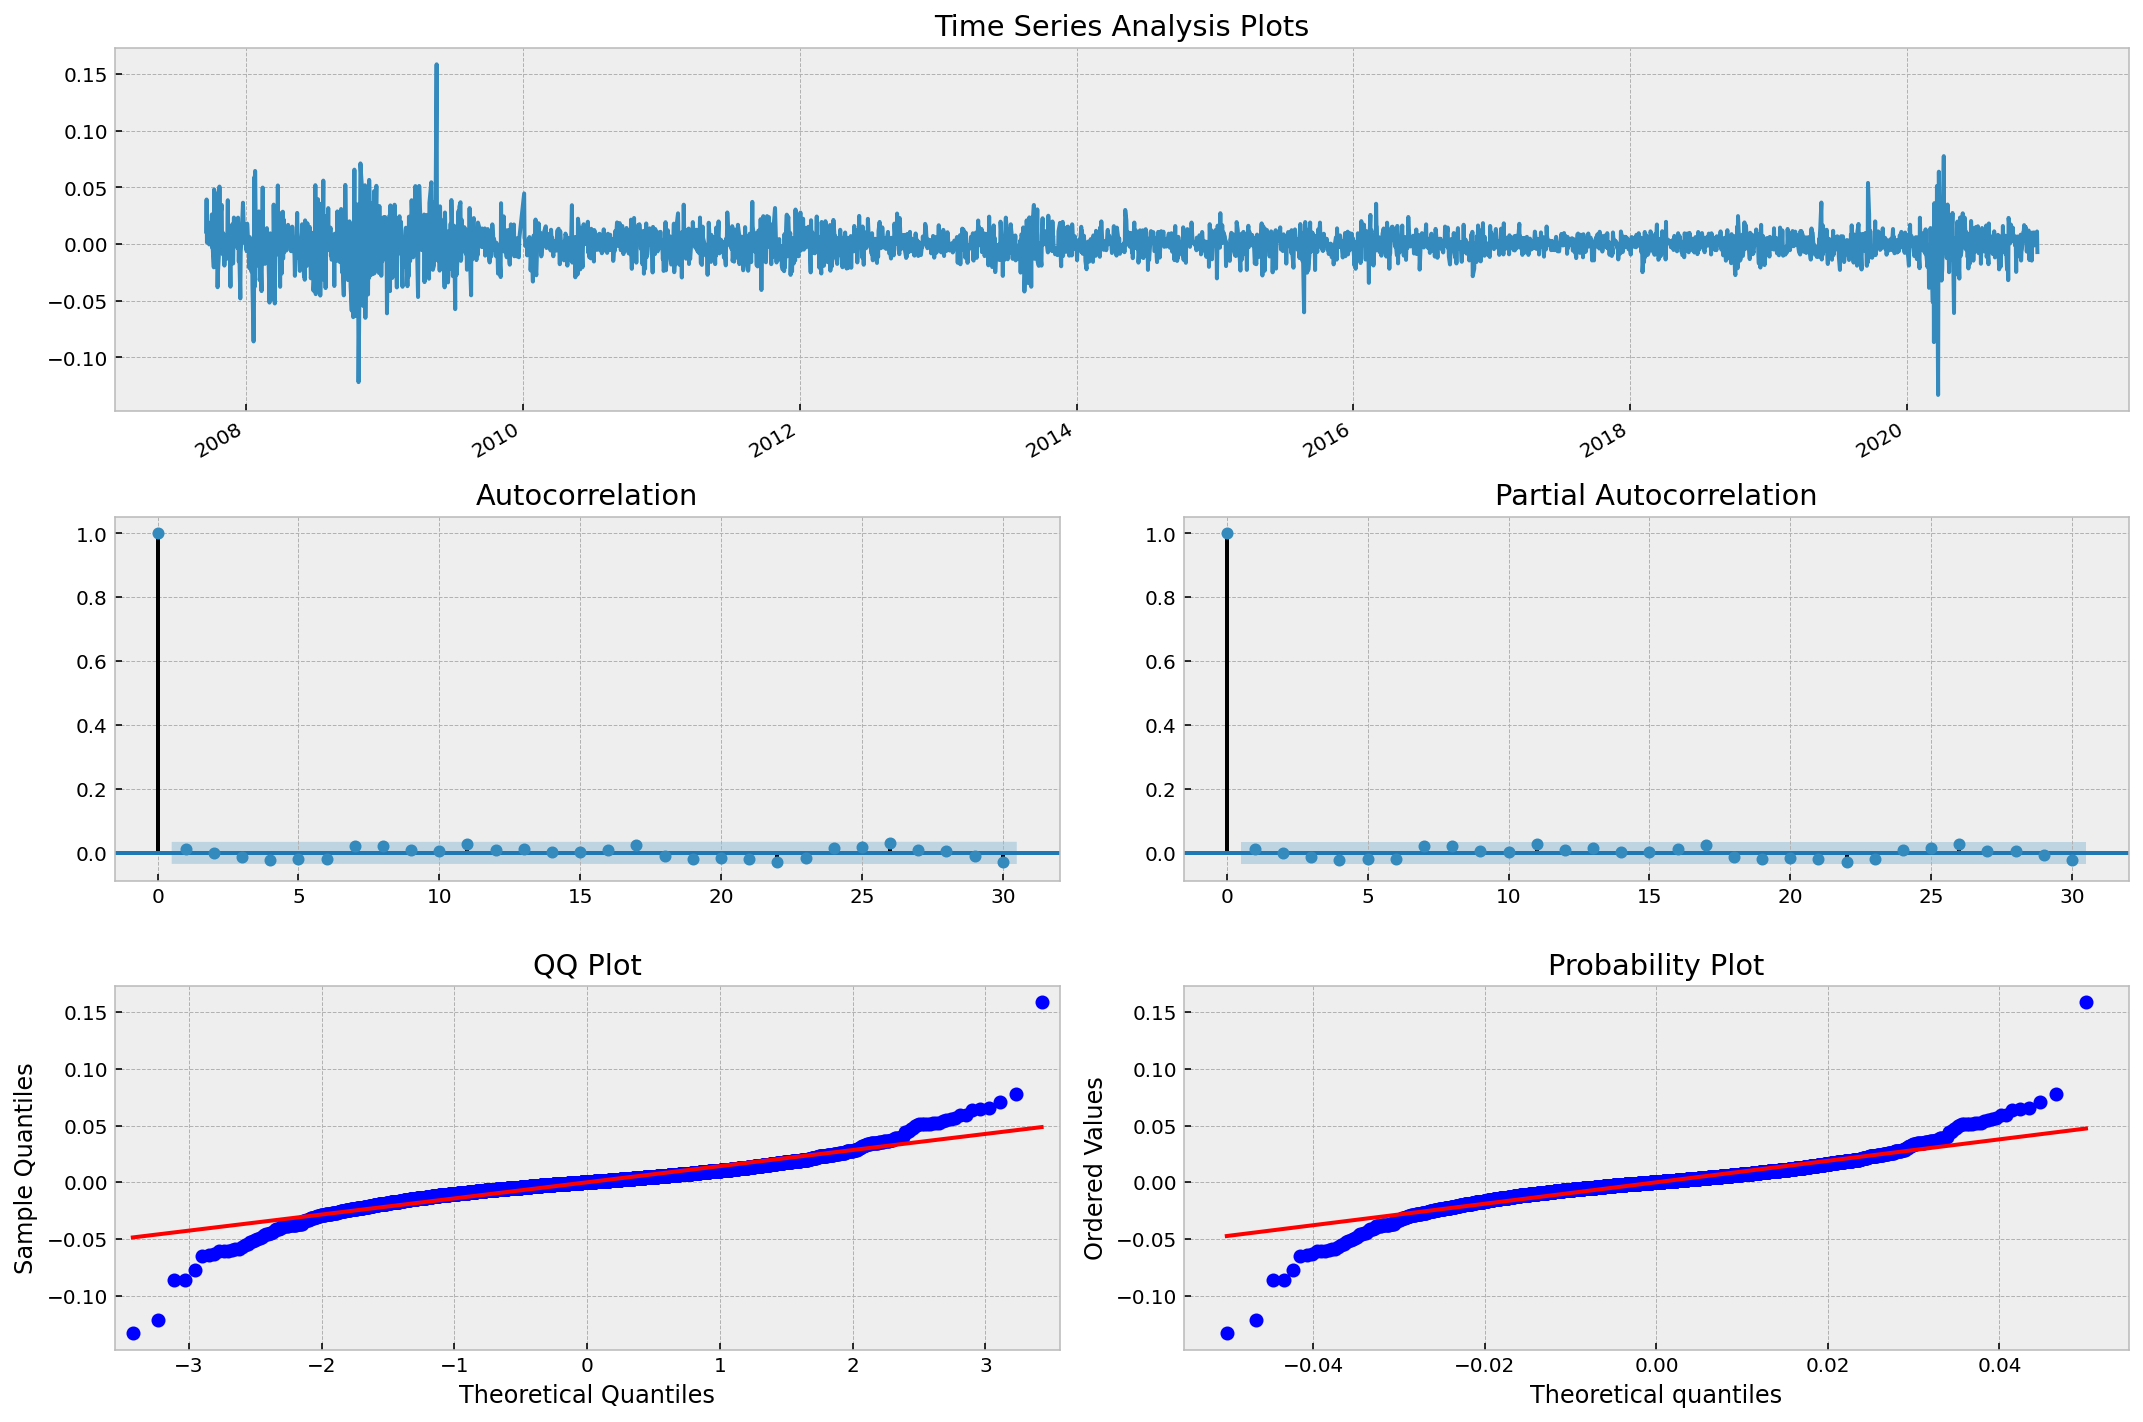

In [12]:
tsplot(ar1.resid, lags=30)

# **Let's Forecast**

In [13]:
# Create a 21 day forecast of Nifty returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = ar1.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = ar1.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(hist.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head(10)

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2020-12-10,0.000871,-0.026947,-0.035689,0.028690,0.037431
2020-12-11,0.000063,-0.027774,-0.036521,0.027900,0.036647
2020-12-12,0.003033,-0.024804,-0.033552,0.030871,0.039618
2020-12-13,0.001419,-0.026418,-0.035165,0.029257,0.038004
2020-12-14,0.000545,-0.027293,-0.036040,0.028382,0.037130
2020-12-15,0.000577,-0.027270,-0.036021,0.028425,0.037175
2020-12-16,-0.001634,-0.029491,-0.038244,0.026222,0.034976
2020-12-17,-0.000410,-0.028288,-0.037048,0.027468,0.036228
2020-12-18,0.000558,-0.027323,-0.036084,0.028438,0.037199
2020-12-19,0.000602,-0.027280,-0.036041,0.028485,0.037246


Text(0.5, 1.0, '21 Day Nifty Return Forecast\nARIMA(7, 7)')

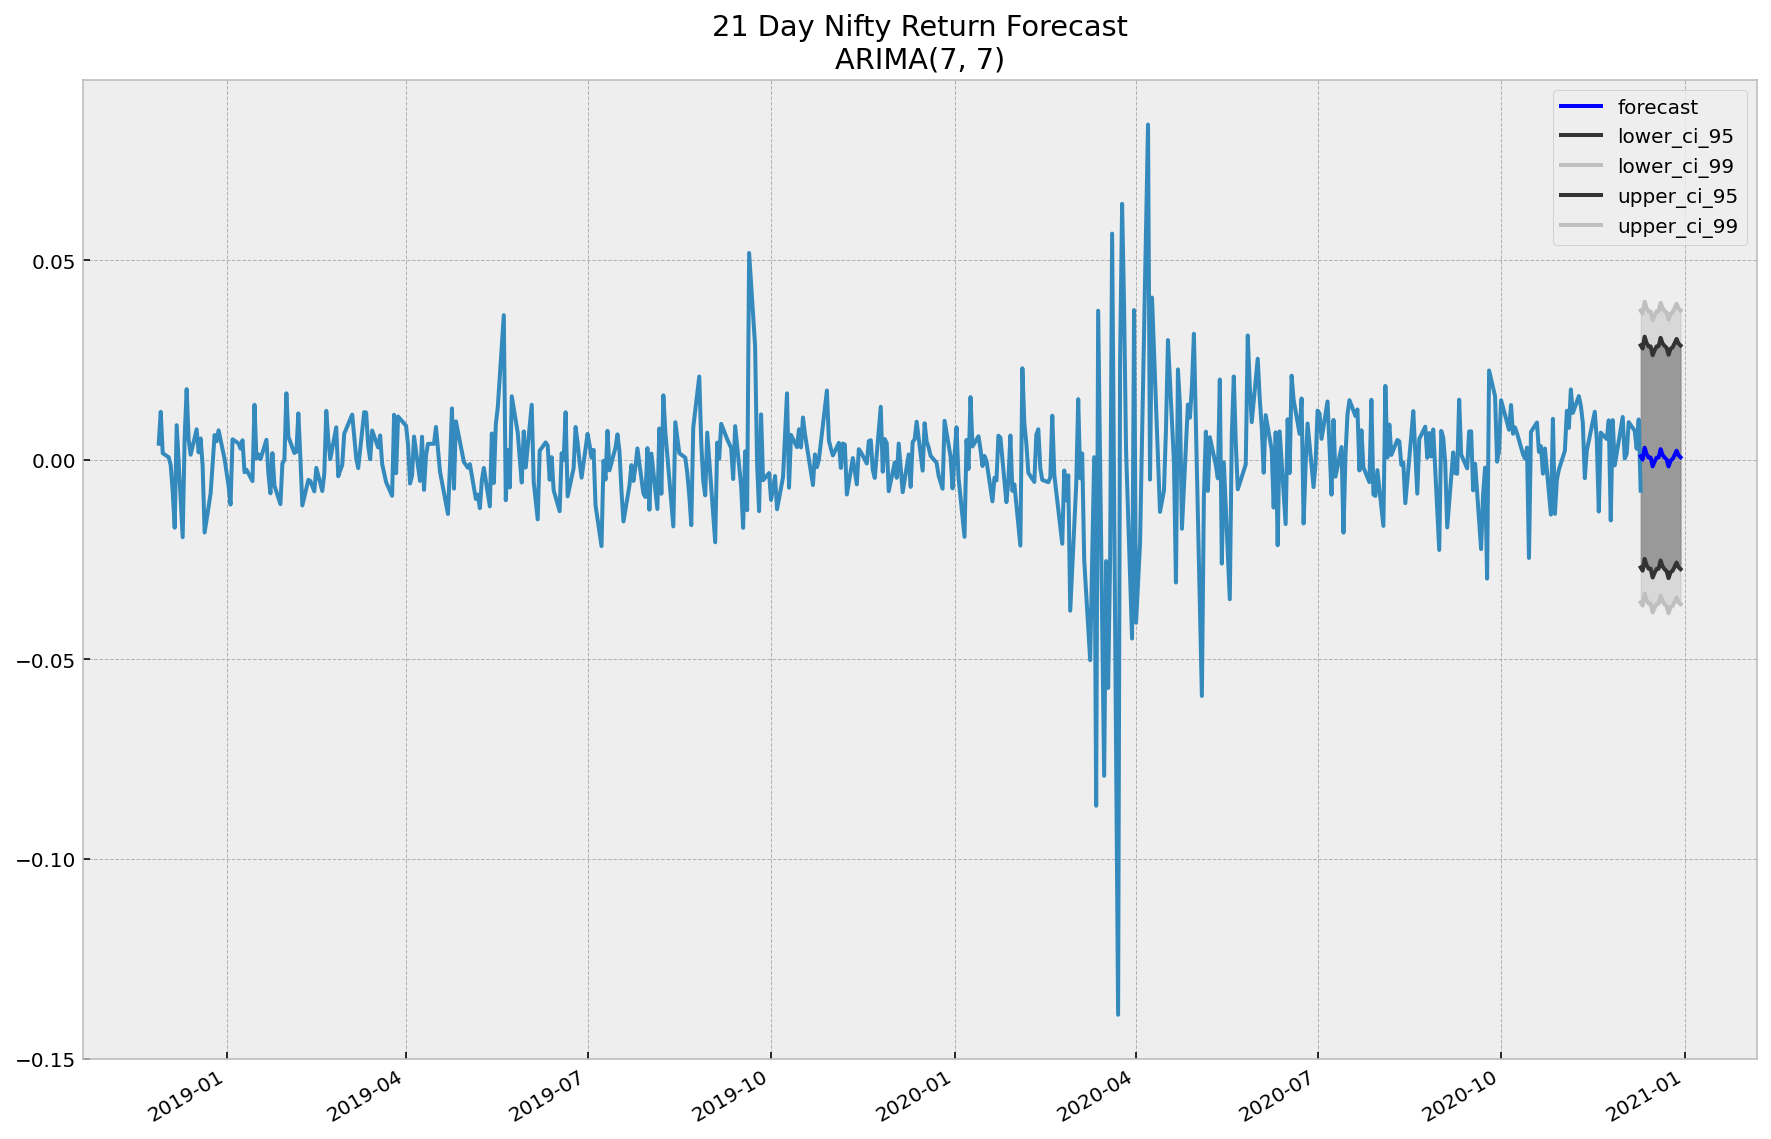

In [14]:

# Plot 21 day forecast for Nifty returns

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = lrets.iloc[-500:].copy()
ts.plot(ax=ax, label='Nifty Returns')
# in sample prediction
#pred = best_mdl.predict(ts.index[0], ts.index[-1])
#pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day Nifty Return Forecast\nARIMA{}'.format(n_steps, (7,7)))